# 使用查询管道和HyDE构建多PDF代理

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/agent/agent_runner/agent_around_query_pipeline_with_HyDE_for_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="在Colab中打开"/></a>

在这个示例中，我们将向您展示如何构建一个多PDF代理，该代理可以跨多个工具进行推理，每个工具对应一个使用HyDE在文档上运行的RAG管道。

作者：https://github.com/DoganK01

## **安装依赖**


In [ ]:
%pip install llama-index-llms-openai
%pip install llama-index
%pip install pyvis

In [ ]:
%pip install arize-phoenix[evals]

In [ ]:
%pip install llama-index-callbacks-arize-phoenix

## **下载数据并导入**


In [ ]:
!mkdir -p 'data/10k/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/uber_2021.pdf' -O 'data/10k/uber_2021.pdf'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/lyft_2021.pdf' -O 'data/10k/lyft_2021.pdf'

In [ ]:
import os

In [ ]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine
from IPython.display import Markdown, display

In [ ]:
# 任务：将python文件中的注释相关的内容翻译成中文，同时保持文件格式的正确性。

from llama_index.core import ：
- SimpleDirectoryReader
- VectorStoreIndex
- StorageContext
- 从存储中加载索引的load_index_from_storage函数

from llama_index.core.tools import ：
- QueryEngineTool
- ToolMetadata

# 定义全局回调设置
from llama_index.core.settings import Settings
from llama_index.core.callbacks import CallbackManager

## 设置可观测性


In [ ]:
callback_manager = CallbackManager()
Settings.callback_manager = callback_manager

In [ ]:
# 设置 Arize Phoenix 用于日志记录/可观测性
import phoenix as px
import llama_index.core

px.launch_app()
llama_index.core.set_global_handler("arize_phoenix")

In [ ]:
os.environ["OPENAI_API_KEY"] = "sk-"

## 设置多文档HyDE查询引擎/工具


我们为我们的多文档系统设置了HyDE查询引擎及其工具。

HyDE，即假设文档嵌入，是一种旨在增强文档检索过程效率的创新检索技术。该方法通过创建一个针对传入查询量身定制的假设文档来运作，随后将其嵌入。所得的嵌入被利用来高效检索与假设对应文档相似的真实文档。


In [ ]:
尝试：
    storage_context = StorageContext.from_defaults(
        persist_dir="./storage/lyft"
    )
    lyft_index = load_index_from_storage(storage_context)

    storage_context = StorageContext.from_defaults(
        persist_dir="./storage/uber"
    )
    uber_index = load_index_from_storage(storage_context)

    index_loaded = True
except:
    index_loaded = False

if not index_loaded:
    # 加载数据
    lyft_docs = SimpleDirectoryReader(
        input_files=["./data/10k/lyft_2021.pdf"]
    ).load_data()
    uber_docs = SimpleDirectoryReader(
        input_files=["./data/10k/uber_2021.pdf"]
    ).load_data()

    # 构建索引
    lyft_index = VectorStoreIndex.from_documents(lyft_docs)
    uber_index = VectorStoreIndex.from_documents(uber_docs)

    # 持久化索引
    lyft_index.storage_context.persist(persist_dir="./storage/lyft")
    uber_index.storage_context.persist(persist_dir="./storage/uber")

In [ ]:
lyft_engine = lyft_index.as_query_engine(similarity_top_k=3)
uber_engine = uber_index.as_query_engine(similarity_top_k=3)


hyde = HyDEQueryTransform(include_original=True)
lyft_hyde_query_engine = TransformQueryEngine(lyft_engine, hyde)
uber_hyde_query_engine = TransformQueryEngine(uber_engine, hyde)

In [ ]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=lyft_hyde_query_engine,
        metadata=ToolMetadata(
            name="lyft_10k",
            description=(
                "Provides information about Lyft financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=uber_hyde_query_engine,
        metadata=ToolMetadata(
            name="uber_10k",
            description=(
                "Provides information about Uber financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
]

## **设置ReAct Agent流水线**

### 什么是ReAct代理

* ReAct是一种使LLM能够进行推理和执行特定任务动作的技术。它结合了链式思维（chain-of-thought）推理和行动规划。它使LLM能够创建推理轨迹和特定任务动作，通过使用内存增强它们之间的协同作用。

* *ReACT代理模型指的是一个框架，该框架将LLM的推理能力与执行可操作步骤的能力集成在一起，创建一个更复杂的系统，该系统能够理解和处理信息、评估情况、采取适当的行动、传达响应以及跟踪正在进行的情况。*


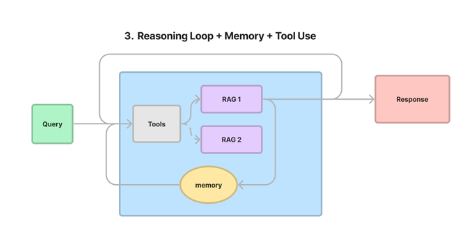

**推理循环**：推理循环允许数据代理根据输入任务选择并与工具交互。

**记忆**：具有记忆访问能力的LLM可以存储和检索数据，非常适合跟踪状态或访问多个来源的应用。记忆保留了过去的互动，使得可以无缝地参考先前的对话点。这一整合过程涉及为相关信息分配记忆槽并在对话期间利用检索机制。通过回忆存储的数据，LLM增强了上下文响应并集成了外部来源，丰富了用户体验。

# 我们将创建的ReAct代理步骤

1.   接受代理输入
2.   使用LLM调用ReAct提示生成下一步行动/工具（或返回响应）。
3. 如果选择了工具/行动，则调用工具管道以执行工具并收集响应（在这种情况下，我们的工具是用于两个文档的HyDE查询引擎工具）。
4. 如果生成了响应，则获取响应。

* 一个`AgentInputComponent`，它允许您将代理输入（任务、状态字典）转换为查询管道的一组输入。

* 一个`AgentFnComponent`：一个通用处理器，允许您接受当前任务、状态以及任何任意输入，并返回一个输出。在本手册中，我们定义了一个格式化ReAct提示的功能组件。不过，您可以将其放置在任何位置。

请注意，传递给`AgentFnComponent`和`AgentInputComponent`的任何函数 **必须** 包含任务和状态作为输入变量，因为这些是代理传递的输入。

请注意，代理查询管道的输出 **必须** 是 `Tuple[AgentChatResponse, bool]`。

## 任务和状态

**任务**：它包含完成用户请求查询所需的信息。用户输入、记忆、元数据、随时间变化的全局状态。

**状态**：一些信息比如记忆。


## **代理输入组件**

为给定的任务生成输入。


In [ ]:
from llama_index.core.agent.react.types import (
    ActionReasoningStep,  # 动作推理步骤
    ObservationReasoningStep,  # 观察推理步骤
    ResponseReasoningStep,  # 响应推理步骤
)
from llama_index.core.agent import Task, AgentChatResponse  # 任务，代理聊天响应
from llama_index.core.query_pipeline import (
    AgentInputComponent,  # 代理输入组件
    AgentFnComponent,  # 代理函数组件
    CustomAgentComponent,  # 自定义代理组件
    QueryComponent,  # 查询组件
    ToolRunnerComponent,  # 工具运行组件
)
from llama_index.core.llms import MessageRole  # 消息角色
from typing import Dict, Any, Optional, Tuple, List, cast  # 导入类型提示

## 代理输入组件
## 这是生成代理输入给其他组件的组件
## 也可以在这里放置初始化逻辑。
def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """代理输入函数。

    返回:
        一个包含输出键和值的字典。如果在定义该组件与其他组件之间的链接时指定了src_key，
        请确保src_key与指定的output_key匹配。

    """
    # 初始化当前推理
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

# 定义Agent提示
在这里我们定义了生成ReAct提示的Agent组件，输出从LLM生成后，解析为一个结构化对象。

在接收到输入后，LLM会使用ReAct agent提示进行调用。

`ReActChatFormatter`基本上使用ReAct提示（Chain-Of-Thought + Acting）方法生成一个完全格式化的ReAct提示。


In [ ]:
from llama_index.core.agent import ReActChatFormatter
from llama_index.core.query_pipeline import InputComponent, Link
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import BaseTool


## 定义提示函数
def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # 将输入添加到推理中
    chat_formatter = ReActChatFormatter()
    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(
    fn=react_prompt_fn, partial_dict={"tools": query_engine_tools}
)

您可以在这里看到ReAct提示：

https://github.com/run-llama/llama_index/blob/6cd92affa5835aa21f823ff985a81f006c496bbd/llama-index-core/llama_index/core/agent/react/prompts.py#L6


## **定义代理输出解析器 + 工具流水线**
一旦LLM给出一个输出，我们就有一个决策树：

1. 如果给出了一个答案，那么我们就完成了。处理输出。

2. 如果给出了一个动作，我们需要使用指定的工具和指定的参数执行指定的工具，然后处理输出。

工具调用可以通过`ToolRunnerComponent`模块来实现。这是一个简单的包装模块，它接受一个工具列表，并可以使用指定的工具名称（每个工具都有一个名称）和工具动作来“执行”。

我们实现了这个整体模块`OutputAgentComponent`，它是`CustomAgentComponent`的子类。

`perse_react_output_fn`函数简单地将从`react_prompt_fn`得到的ReAct提示解析为推理步骤。

在这种情况下，ReAct代理选择使用工具或完成工具，并简单地获取输出，这将适合于代理的聊天响应(`AgentChatResponse`)。

`run_tool_fn`函数简单地运行所选的工具。

最后，根据代理输出格式，通过应用`process_agent_response_fn`函数来编辑传入的输出。


In [ ]:
from typing import Set, Optional
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.llms import ChatResponse
from llama_index.core.agent.types import Task


def parse_react_output_fn(
    task: Task, state: Dict[str, Any], chat_response: ChatResponse
):
    """将ReAct输出解析为推理步骤。"""
    output_parser = ReActOutputParser()
    reasoning_step = output_parser.parse(chat_response.message.content)
    return {"done": reasoning_step.is_done, "reasoning_step": reasoning_step}


parse_react_output = AgentFnComponent(fn=parse_react_output_fn)


def run_tool_fn(
    task: Task, state: Dict[str, Any], reasoning_step: ActionReasoningStep
):
    """运行工具并处理工具输出。"""
    tool_runner_component = ToolRunnerComponent(
        query_engine_tools, callback_manager=task.callback_manager
    )
    tool_output = tool_runner_component.run_component(
        tool_name=reasoning_step.action,
        tool_input=reasoning_step.action_input,
    )
    observation_step = ObservationReasoningStep(observation=str(tool_output))
    state["current_reasoning"].append(observation_step)
    # TODO: 获取输出

    return {"response_str": observation_step.get_content(), "is_done": False}


run_tool = AgentFnComponent(fn=run_tool_fn)


def process_response_fn(
    task: Task, state: Dict[str, Any], response_step: ResponseReasoningStep
):
    """处理响应。"""
    state["current_reasoning"].append(response_step)
    response_str = response_step.response
    # 现在我们完成了这一步，将其放入内存
    state["memory"].put(ChatMessage(content=task.input, role=MessageRole.USER))
    state["memory"].put(
        ChatMessage(content=response_str, role=MessageRole.ASSISTANT)
    )

    return {"response_str": response_str, "is_done": True}


process_response = AgentFnComponent(fn=process_response_fn)


def process_agent_response_fn(
    task: Task, state: Dict[str, Any], response_dict: dict
):
    """处理代理响应。"""
    return (
        AgentChatResponse(response_dict["response_str"]),
        response_dict["is_done"],
    )


process_agent_response = AgentFnComponent(fn=process_agent_response_fn)

# **拼接代理查询管道**
现在我们可以将顶层代理管道拼接起来：agent_input -> react_prompt -> llm -> react_output。

最后一个组件是if-else组件，用于调用子组件。


In [ ]:
from llama_index.core.query_pipeline import QueryPipeline as QP

qp = QP(verbose=True)

In [ ]:
from llama_index.core.query_pipeline import QueryPipeline as QP
from llama_index.llms.openai import OpenAI

qp.add_modules(
    {
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-4-1106-preview"),
        "react_output_parser": parse_react_output,
        "run_tool": run_tool,
        "process_response": process_response,
        "process_agent_response": process_agent_response,
    }
)

In [ ]:
# 将输入链接到反应提示以解析出响应（工具操作/输入或观察）
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output_parser"])

# 从反应输出到工具调用添加条件链接（如果未完成）
qp.add_link(
    "react_output_parser",
    "run_tool",
    condition_fn=lambda x: not x["done"],
    input_fn=lambda x: x["reasoning_step"],
)
# 从反应输出到最终响应处理添加条件链接（如果完成）
qp.add_link(
    "react_output_parser",
    "process_response",
    condition_fn=lambda x: x["done"],
    input_fn=lambda x: x["reasoning_step"],
)

# 无论是响应处理还是工具输出处理，都添加链接到最终代理响应
qp.add_link("process_response", "process_agent_response")
qp.add_link("run_tool", "process_agent_response")

## **可视化查询管道**


In [ ]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(qp.clean_dag)
print(net)

{
    "Nodes": [
        "agent_input",
        "react_prompt",
        "llm",
        "react_output_parser",
        "run_tool",
        "process_response",
        "process_agent_response"
    ],
    "Edges": [
        {
            "src_key": null,
            "dest_key": null,
            "condition_fn": null,
            "input_fn": null,
            "width": 1,
            "from": "agent_input",
            "to": "react_prompt",
            "arrows": "to"
        },
        {
            "src_key": null,
            "dest_key": null,
            "condition_fn": null,
            "input_fn": null,
            "width": 1,
            "from": "react_prompt",
            "to": "llm",
            "arrows": "to"
        },
        {
            "src_key": null,
            "dest_key": null,
            "condition_fn": null,
            "input_fn": null,
            "width": 1,
            "from": "llm",
            "to": "react_output_parser",
            "arrows": "to"
        },
    

In [ ]:
# 将网络保存为"agent_dag.html"
net.write_html("agent_dag.html")

In [ ]:
from IPython.display import display, HTML

# 读取HTML文件的内容
with open("agent_dag.html", "r") as file:
    html_content = file.read()

# 显示HTML内容
display(HTML(html_content))

## 在我们的查询引擎周围设置代理工作程序


In [ ]:
from llama_index.core.agent import QueryPipelineAgentWorker
from llama_index.core.callbacks import CallbackManager

agent_worker = QueryPipelineAgentWorker(qp)
agent = agent_worker.as_agent(
    callback_manager=CallbackManager([]), verbose=True
)

## **运行代理程序**


In [ ]:
# 开始任务
task = agent.create_task(
    "Uber的管理层对财务报告内部控制的报告是什么？"
)

In [ ]:
step_output = agent.run_step(task.task_id)

> Running step 26c623b9-0864-45d9-9f91-f893a4696727. Step input: What was Uber's Management's Report on Internal Control over Financial Reporting?
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='aa7707d1-a35a-4d96-b2cc-ded765a3a3e2' input="What was Uber's Management's Report on Internal Control over Financial Reporting?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functool...

> Running module react_prompt with input: 
input: What was Uber's Management's Report on Internal Control over Financial Reporting?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\n\n## Too...

> Runni

In [ ]:
print(step_output)

Observation: {'output': ToolOutput(content="Uber's Management's Report on Internal Control over Financial Reporting stated that they excluded The Drizly Group, Inc. and TupeloParent, Inc. from their assessment of internal control over financial reporting as of December 31, 2021 due to their acquisition by the company during 2021. The report also mentioned that Drizly and TupeloParent were excluded from the audit of internal control over financial reporting.", tool_name='uber_10k', raw_input={'input': "What was Uber's Management's Report on Internal Control over Financial Reporting?"}, raw_output=Response(response="Uber's Management's Report on Internal Control over Financial Reporting stated that they excluded The Drizly Group, Inc. and TupeloParent, Inc. from their assessment of internal control over financial reporting as of December 31, 2021 due to their acquisition by the company during 2021. The report also mentioned that Drizly and TupeloParent were excluded from the audit of int

In [ ]:
# 开始任务
task = agent.create_task("2021年Lyft的营收增长情况是多少？")

In [ ]:
step_output = agent.run_step(task.task_id)

> Running step ee9eff5f-a4be-4b76-bae6-d05d2af41ecd. Step input: What was Lyft's revenue growth in 2021?
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7a038afc-3ead-4b0c-a924-41cd4f465270' input="What was Lyft's revenue growth in 2021?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: What was Lyft's revenue growth in 2021?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\n\n## Too...

> Running module react_output_parser with input: 
chat_response: assistant: Thought: I need

In [ ]:
step_output = agent.run_step(task.task_id)

> Running step 279c7a46-ce9d-4202-bec4-01d5c1ed50bd. Step input: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7a038afc-3ead-4b0c-a924-41cd4f465270' input="What was Lyft's revenue growth in 2021?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: What was Lyft's revenue growth in 2021?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\n\n## Too...

> Running module react_output_parser with input: 
chat_response: assistant: Thought: The user has repeated the question, but t

In [ ]:
step_output.is_last

True

In [ ]:
print(step_output)

Uber's Management's Report on Internal Control over Financial Reporting for the year ended December 31, 2021, stated that management excluded The Drizly Group, Inc. ("Drizly") and TupeloParent, Inc. ("Transplace") from its assessment of internal control over financial reporting. This exclusion was due to their acquisition by the company during 2021. Drizly and Transplace were wholly-owned subsidiaries whose total assets and total revenues collectively represented approximately 3% and 4%, respectively, of the related consolidated financial statement amounts for the year.


In [ ]:
response = agent.finalize_response(task.task_id)

In [ ]:
print(str(response))

Uber's Management's Report on Internal Control over Financial Reporting for the year ended December 31, 2021, stated that management excluded The Drizly Group, Inc. ("Drizly") and TupeloParent, Inc. ("Transplace") from its assessment of internal control over financial reporting. This exclusion was due to their acquisition by the company during 2021. Drizly and Transplace were wholly-owned subsidiaries whose total assets and total revenues collectively represented approximately 3% and 4%, respectively, of the related consolidated financial statement amounts for the year.
